Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/wei-tianyu/deep-remote-prior
!mv deep-remote-prior/* ./

In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import time

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *
from utils.sr_utils import load_LR_HR_imgs_sr
from threading import Thread
import queue
from models.skip import skip

from utils.utils import *  # auxiliary functions
from utils.data import Data  # class that holds img, psnr, time

from skimage.restoration import denoise_nl_means

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255

random_seed = 545
torch.manual_seed(random_seed)

In [4]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Constants

In [5]:
SIGMA = 25
# graphs labels:
X_LABELS = ['Iterations']*3
Y_LABELS = ['PSNR between x and net (db)', 'PSNR with original image (db)', 'loss']

# Algorithm NAMES (to get the relevant image: use data_dict[alg_name].img)
# for example use data_dict['Clean'].img to get the clean image
ORIGINAL = 'Clean'
CORRUPTED = 'Noisy'
NLM = 'NLM'
DIP_NLM = 'DRED (NLM)'


# Load image

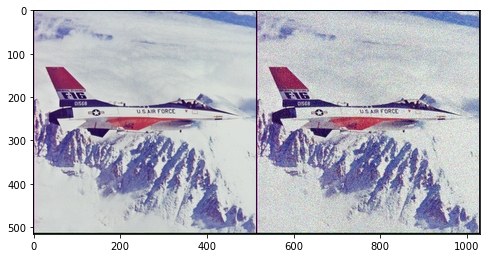

In [6]:
imgs = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')
img_flash = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_00_flash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_flash_np = pil_to_np(img_flash)

img_noflash = load_LR_HR_imgs_sr('data/flash_no_flash/cave01_01_noflash.jpg', -1, 1, enforse_div32='CROP')['HR_pil']
img_noflash_np = pil_to_np(img_noflash)

g = plot_image_grid([img_flash_np, img_noflash_np],3,12)

# Setup

In [7]:
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 0.0 # set to 1./20. for sigma=50
LR = 0.1

OPTIMIZER='adam' # 'LBFGS'
show_every = 50
exp_weight=0.99

input_depth = 3
figsize = 6
net_input =np_to_torch(img_flash_np).type(dtype)
num_iter = 601

net = skip(input_depth, 3, num_channels_down = [128, 128, 128, 128, 128], 
                        num_channels_up   = [128, 128, 128, 128, 128],
                        num_channels_skip = [4, 4, 4, 4, 4], 
                        upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'], 
                        need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noflash_np).type(dtype)

Number of params: 2217831


# The Non Local Means denoiser 

In [10]:
def non_local_means(noisy_np_img, sigma, fast_mode=True):
    """ get a numpy noisy image
        returns a denoised numpy image using Non-Local-Means
    """ 
    sigma = sigma / 255.
    h = 0.6 * sigma if fast_mode else 0.8 * sigma
    patch_kw = dict(h=h,                   # Cut-off distance, a higher h results in a smoother image
                    sigma=sigma,           # sigma provided
                    fast_mode=fast_mode,   # If True, a fast version is used. If False, the original version is used.
                    patch_size=5,          # 5x5 patches (Size of patches used for denoising.)
                    patch_distance=6,      # 13x13 search area
                    multichannel=False)
    denoised_img = []
    n_channels = noisy_np_img.shape[0]
    for c in range(n_channels):
        denoise_fast = denoise_nl_means(noisy_np_img[c, :, :], **patch_kw)
        denoised_img += [denoise_fast]
    return np.array(denoised_img, dtype=np.float32)

In [4]:
# Soft Thresholding function
def soft(z, lam): 
  result = z - torch.clamp(z, -lam, lam)
  return result

# Optimize

In [14]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
admm_iter = 6000
sigma_f = 3
y = img_noflash_np
x, u = y.copy(), np.zeros_like(y)
# avg, avg2, avg3 = np.rint(y), np.rint(y), np.rint(y)
y_torch = np_to_torch(y).type(dtype)
method = "fixed_point"

i = 1
def closure():
    
    #sorry to use such many global vars...
    global i, out_avg, psrn_noisy_last, last_net, net_input, method, org_img, data_dict, non_local_means, admm_iter, sigma_f, y, x, u, y_torch, method

     #time
    if (i == 1):
      start = time.time()
    
     beta=.5
    mu=0.8 * 0.996**i
    #mu=0.3 * 0.999**i
    update_iter = 10
    lam = 0.003
    #lam = 0.02

    denoiser_function = non_local_means


    #initialize f_x
    f_x = x.copy()

    
    #step1: update network
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = soft((1-mu)* net(net_input) + mu * y_torch, mu * lam)
    out_np = torch_to_np(out)
    
    # loss:
    total_loss = mse(out, y_torch)
    total_loss.backward()

    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)

        print (i, "runtime:", time.time() - start)
    
    # # Smoothing
    # if out_avg is None:
    #     out_avg = out.detach()
    # else:
    #     out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
        
    
    # psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # # Note that we do not have GT for the "snail" example
    # # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    # print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    # if  PLOT and i % show_every == 0:
    #     plot_image_grid([np.clip(out_np, 0, 1), 
    #                      np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # # Backtracking
    # if i % show_every:
    #     if psrn_noisy - psrn_noisy_last < -5: 
    #         print('Falling back to previous checkpoint.')

    #         for new_param, net_param in zip(last_net, net.parameters()):
    #             net_param.data.copy_(new_param.cuda())

    #         return total_loss*0
    #     else:
    #         last_net = [x.detach().cpu() for x in net.parameters()]
    #         psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


C:\Users\wtyna\anaconda3\envs\deep-image-prior\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\wtyna\anaconda3\envs\deep-image-prior\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_noflash_np], factor=13);